In [ ]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading and Processing Data

In [ ]:
#path of data set
directory = "/content/drive/MyDrive/Medicinal Leaf Dataset/dataset"

In [ ]:
batch_size = 64
IMG_SIZE = (224, 224, 3)
IMAGE_RES = 224
BATCH_SIZE = 32

In [ ]:
#creating train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 2982 files belonging to 39 classes.
Using 2386 files for training.


In [ ]:
#creating train validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 2982 files belonging to 39 classes.
Using 596 files for validation.


In [ ]:
#getting the name of classes
class_names = train_ds.class_names
print(class_names)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Andrographis paniculata(Nilavembu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Coleus amboinicus(Doddapatre)', 'Curcuma longa(Turmeric)', 'Cymbopogon(Lemongrass)', 'Eclipta prostrata( Bhringraj)', 'Eucalyptus teriticornis(Eucalyptus)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Phyllanthus emblica(Amala)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)'

In [ ]:
#saving class names
np.save("/content/drive/MyDrive/artifact/updatedclassnames.npy", class_names)

In [ ]:
NUM_CLASSES = 39

## Sample of Training data

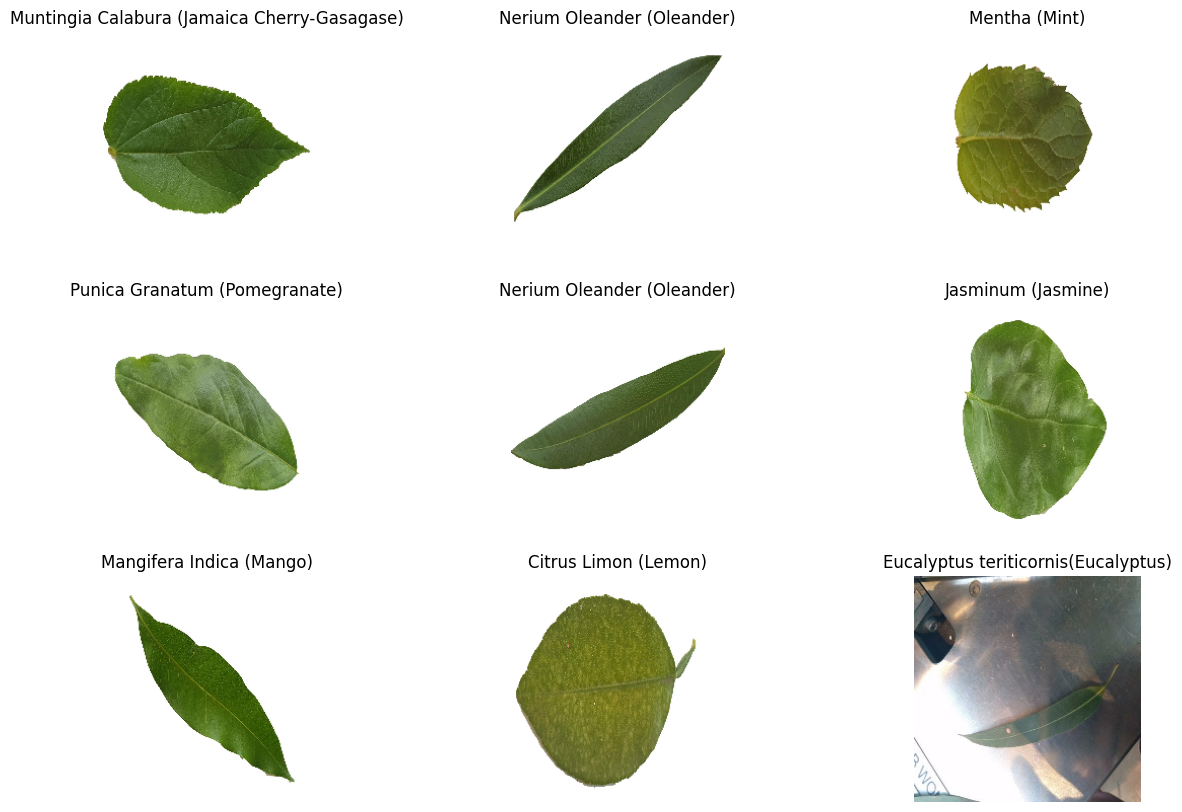

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
#provides pipeling for reading data and training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

## Using Pre-Trained ResNet50V2

In [ ]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
pre_trained_layers.trainable = False

In [ ]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
#Creating custom model
#NUM_CLASSES = 30
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [ ]:
EPOCHS = 10
LR = 1e-3

In [ ]:
#LR = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (1, 2048)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 output (Dense)              (1, 39)                   79911     
                                                                 
Total params: 23644711 (90.20 MB)
Trainable params: 79911 (312.15 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [ ]:
#training the model
#EPOCHS = 100
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/10
38/38 [==============================] - 806s 19s/step - loss: 2.3436 - accuracy: 0.3676 - val_loss: 1.1651 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 2/10
38/38 [==============================] - 498s 13s/step - loss: 1.0111 - accuracy: 0.7452 - val_loss: 0.7580 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 3/10
38/38 [==============================] - 541s 14s/step - loss: 0.7078 - accuracy: 0.8265 - val_loss: 0.6007 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 4/10
38/38 [==============================] - 547s 14s/step - loss: 0.5413 - accuracy: 0.8680 - val_loss: 0.5190 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 5/10
38/38 [==============================] - 490s 13s/step - loss: 0.4612 - accuracy: 0.8873 - val_loss: 0.4800 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 6/10
38/38 [==============================] - 537s 14s/step - loss: 0.4104 - accuracy: 0.9040 - val_loss: 0.4291 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 7/10
38/38 [==============================] - 487s 13s/step - lo

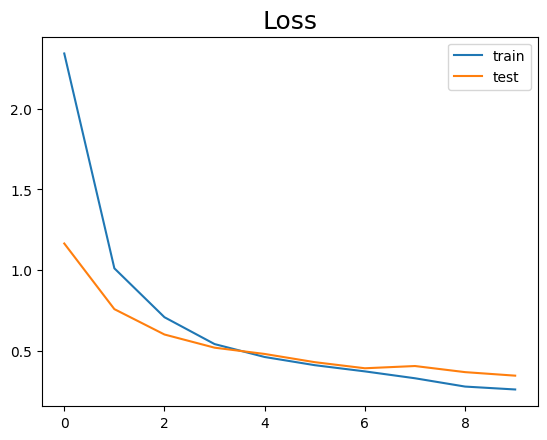

In [ ]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

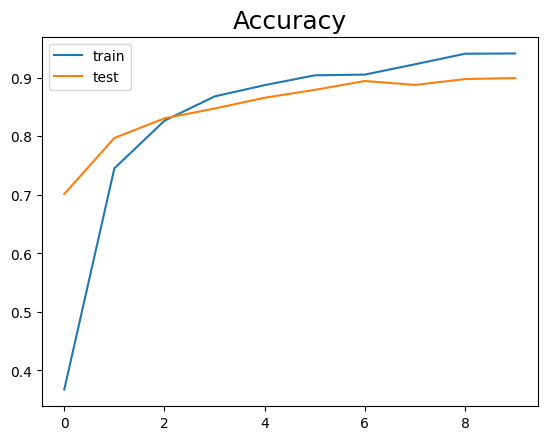

In [ ]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

## Model Performance Analysis

In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
Y_train = []
X_train = []

In [ ]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [ ]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [ ]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

75/75 [==============================] - 373s 5s/step


In [ ]:
y_train_pred_prob.shape

(2386, 39)

In [ ]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

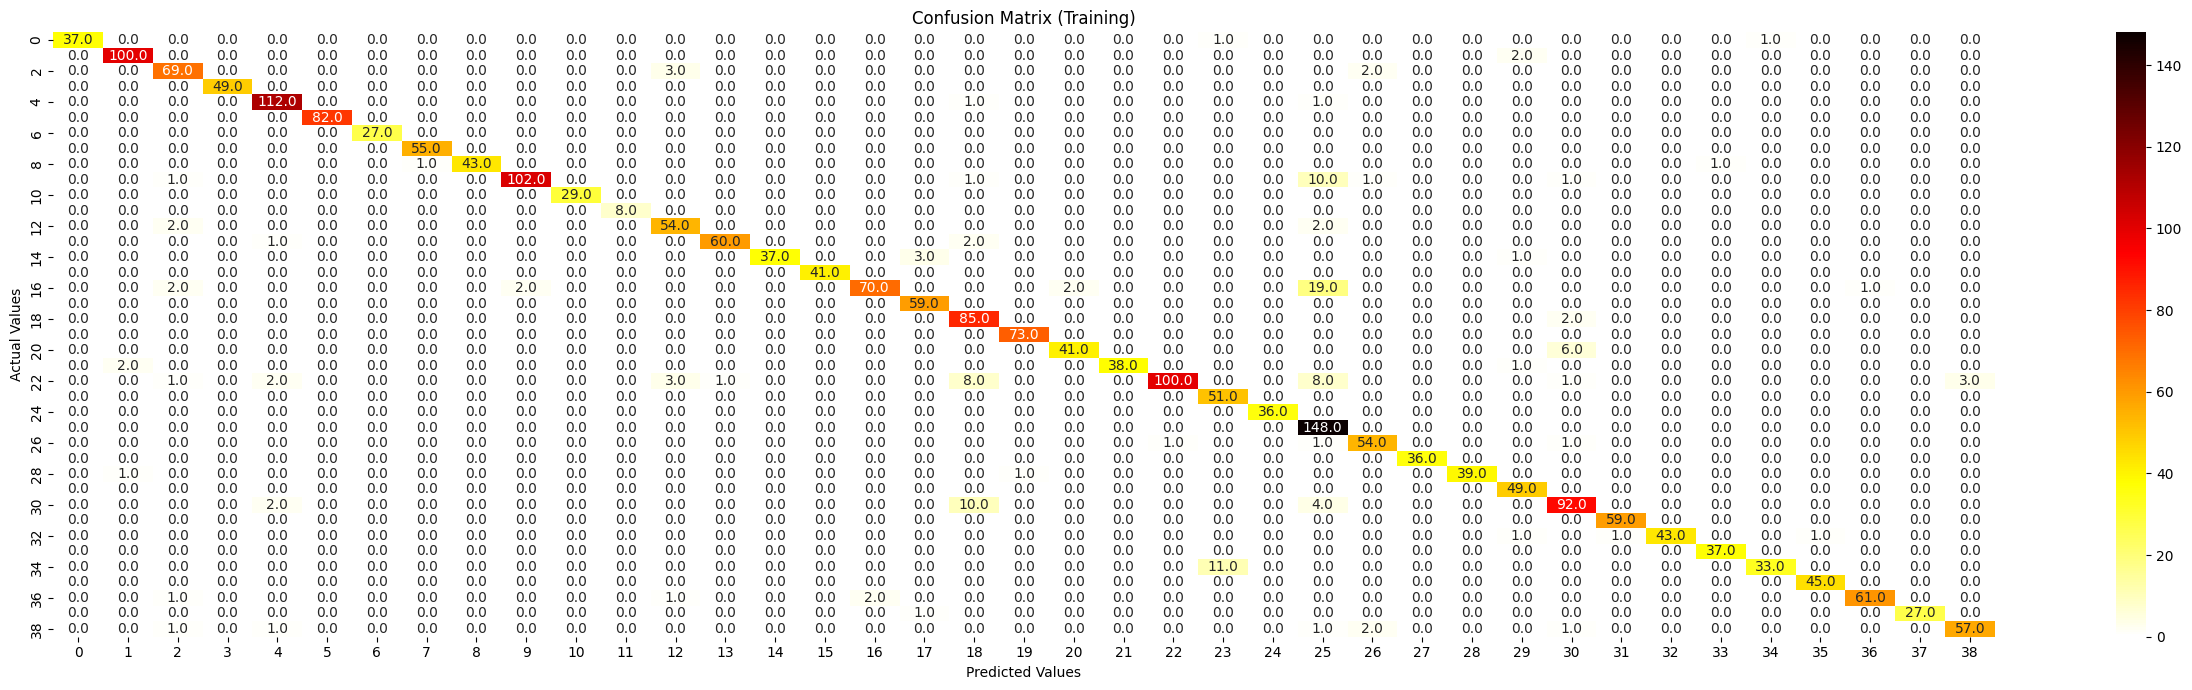

In [ ]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.97      0.98      0.98       102
           2       0.90      0.93      0.91        74
           3       1.00      1.00      1.00        49
           4       0.95      0.98      0.97       114
           5       1.00      1.00      1.00        82
           6       1.00      1.00      1.00        27
           7       0.98      1.00      0.99        55
           8       1.00      0.96      0.98        45
           9       0.98      0.88      0.93       116
          10       1.00      1.00      1.00        29
          11       1.00      1.00      1.00         8
          12       0.89      0.93      0.91        58
          13       0.98      0.95      0.97        63
          14       1.00      0.90      0.95        41
          15       1.00      1.00      1.00        41
          16       0.97      0.73      0.83   

In [ ]:
X_test = []
y_test = []

In [ ]:
for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

19/19 [==============================] - 109s 6s/step


In [ ]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38], dtype=int32)

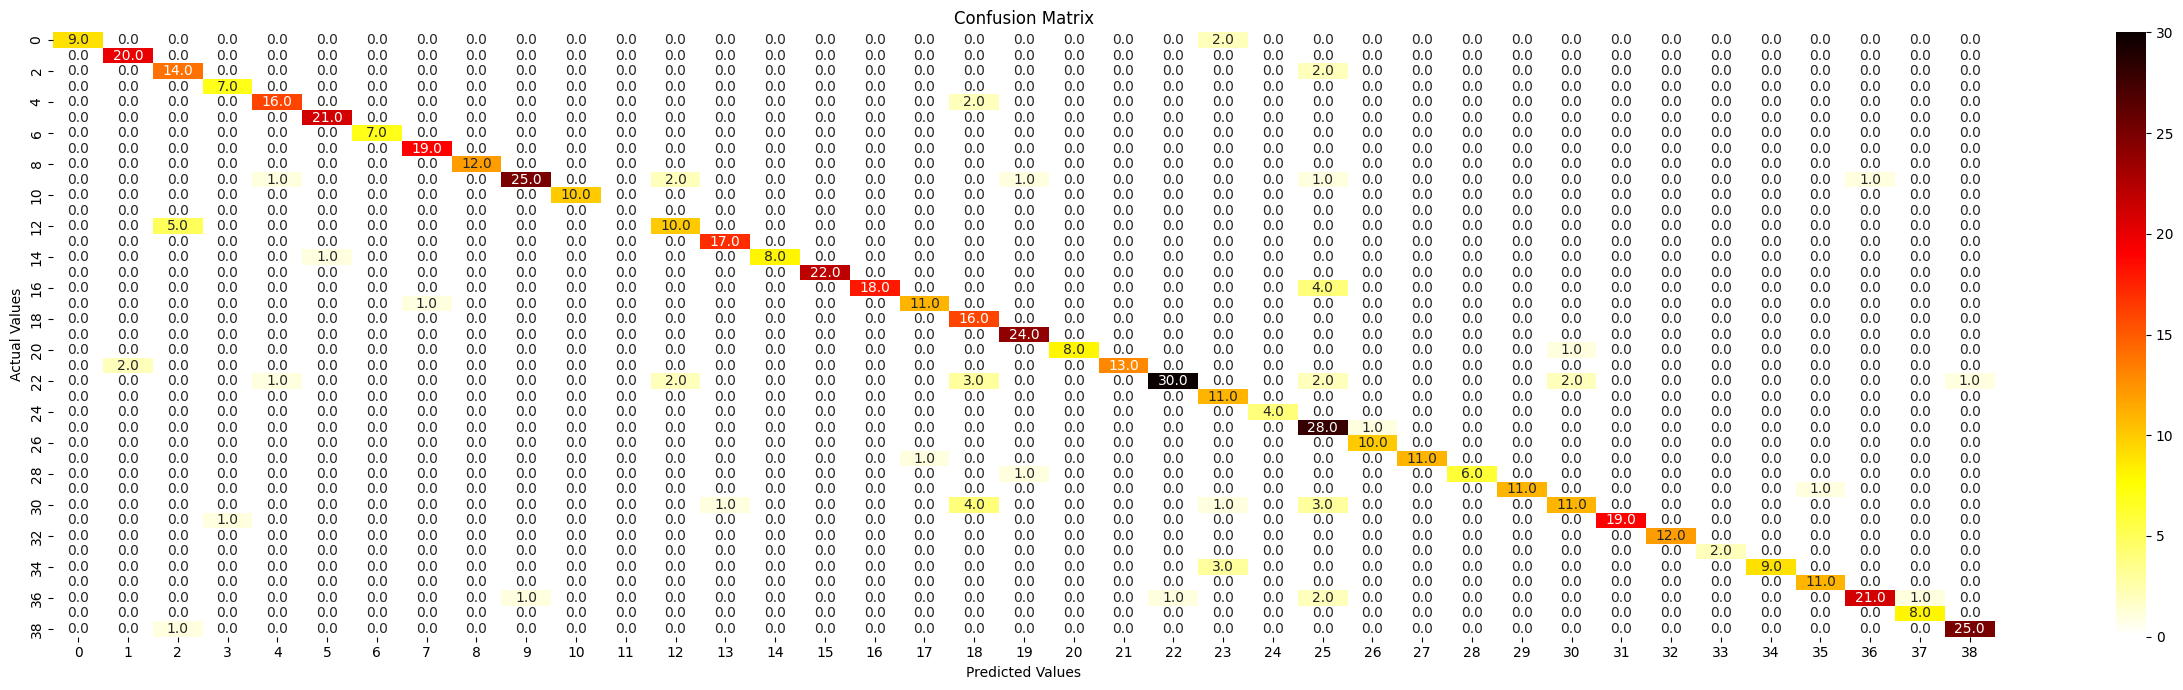

In [ ]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.91      1.00      0.95        20
           2       0.70      0.88      0.78        16
           3       0.88      1.00      0.93         7
           4       0.89      0.89      0.89        18
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00         7
           7       0.95      1.00      0.97        19
           8       1.00      1.00      1.00        12
           9       0.96      0.81      0.88        31
          10       1.00      1.00      1.00        10
          12       0.71      0.67      0.69        15
          13       0.94      1.00      0.97        17
          14       1.00      0.89      0.94         9
          15       1.00      1.00      1.00        22
          16       1.00      0.82      0.90        22
          17       0.92      0.92      0.92       

## Saving Model

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
save_model(model, '/content/drive/MyDrive/Paper/updatednewmodel.h5')